In [3]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import scipy.misc as mis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

deg_k_smooth_spl = 10
extra_spl = 0 # 0 extrapolation , 1 zero; 2 error; 3 boundary values
interp_spl = lambda space, funct : interp.UnivariateSpline(space, funct, k=deg_k_smooth_spl, ext=extra_spl)

interp_funct = lambda space, funct : interp.interp1d(space, funct, kind='linear', fill_value='extrapolate')

The isotropic metric in spherical coordinates is

$\mathrm{d}s^2 = -N^2(t,r) \mathrm{d}t^2 + \psi^4(t,r)\big(\mathrm{d}r^2 + r^2\mathrm{d}\theta^2 + r^2\sin^2\theta\,\mathrm{d}\phi^2\big)$,

and the matter Lagrangian is a free scalar field,

$\mathcal{L}_{\text{matter}} = -(\partial_\mu \Phi + ie A_\mu\Phi)g^{\mu\nu}(\partial_\nu \Phi^* - ie A_\nu\Phi^*)-\lambda (|\Phi|^2-v^2)^2-\frac{1}{4}|F_{\mu\nu}|^2$. We also decompose the complex scalar $\Phi$ to two real scalars $\Phi = \frac{1}{\sqrt{2}}(\phi_1 + i\phi_2)$ when simulation is needed.

We use the radiation gauge $\mathbf{k}\cdot\mathbf{A}=0$ and spherical symmetry to set $A_\mu = (a,0,0,0)$, where the only non-vanishing component is $A_t=a$.

Define the conjugate of momentum for $\Phi$ to be $p$, for $\psi$ to be $K$ (foliated 3D extrinsic curvature) and for $a$ to be $g$. Note that the momentum for lapse $N$ vanishes and shift function itself vanishes in this isotropic coordinates. Here, $\kappa^2 = 8\pi G_{\text{N}}$. The 7 equations of motions are, from top to bottom, definition of $p$, EOM for $\chi$, definition of $K$, the Einstein's equations for $G_{rt}$, $\frac{1}{\psi^4}G_{rr}+\frac{1}{N^2}G_{tt}$, $G_{tt}$ and $\frac{1}{r^2}G_{\theta\theta}-G_{rr}$:

1. $\dot{\Phi} = \frac{N}{\psi^6}p - iqa\Phi$,

2. $a' = \frac{N}{\psi^2}g$

3. $\dot{p} = \frac{1}{r^2}\partial_r(r^2N\psi^2\Phi')-2\lambda \psi^6 N\Phi^*(|\Phi|^2-v^2) -iqap$,

4. $\dot{g} = iqN\psi^2 (\Phi\Phi^*\,\!' - \Phi^* \Phi') $

    $= qN\psi^2(\phi_1 \phi_2' - \phi_1'\phi_2) $

5. $\dot{\psi} = -\frac{N\psi K}{6}$,

6. $\frac{K'}{3} = \frac{\kappa^2}{\psi^6}\Big(\Phi' p^* + \Phi^*\,\!' p \Big)$,

7. $\frac{\dot{K}}{N} = K^2-\frac{6\psi'}{\psi^5}\Big(\frac{\psi'}{\psi}+\frac{1}{r}\Big) - \frac{3N'}{N\psi^4}\Big(\frac{2\psi'}{\psi} + \frac{1}{r}\Big)-\frac{6}{r\psi^5}(2\psi'+r\psi'')- 3\kappa^2 \Big( \frac{g^2}{2\psi^8} + V(\Phi) \Big)$,

8. $-\frac{4}{r\psi^5}(2\psi'+r\psi'') = \frac{\kappa^2}{2}\Big(\frac{2\Phi'\Phi^*\,\!'}{\psi^4} +\frac{2pp^*}{\psi^{12}}+ \frac{g^2}{\psi^8} + 2V(\Phi)\Big)-\frac{K^2}{3}$,

9. $\frac{2r}{\psi^2}\partial_r\Big(\frac{\psi'}{r\psi^3}\Big) +\frac{r}{N}\partial_r\Big(\frac{N'}{r\psi^4}\Big)=-\frac{\kappa^2}{\psi^4}\Big( 2\Phi'\Phi^*\,\!' - \frac{g^2}{\psi^4} \Big)$.

In [4]:
kap = 1.0
lamb = 3.
vev = 0.0
q=1.0
#m2chi = 1.
epsilon_phi = 1e-7

kapsq = kap**2
vevsq=vev**2

m_schwarz = 1.0
q_schwarz = 0.5
r_min = 0.44
r_max = 1000.
r_div = int(1e3)

print('The horizon is at r = ' + str(np.sqrt(m_schwarz**2-q_schwarz**2)/2.))

print("spatial step size = ", str((r_max-r_min)/r_div))

rr = np.linspace(r_min, r_max, r_div)
logit = lambda x: np.log(np.abs(x))

The horizon is at r = 0.433012701892
('spatial step size = ', '0.99956')


## One dimensional radial action

We approach this problem as a 1-dimension ODE. We define the velocity fields $A$ abd $B$ for simplifying the equations. The order of the equations are also the order of the ODEint variables in the I/O vector.

$A' = \frac{r^2 \psi^5 K^2}{12} - \frac{r^2 \kappa^2}{8}\Big( 2\psi\Phi'\Phi^*\,\!' + \frac{2pp^*}{\psi^7} + \frac{C^2}{r^4\psi^3}  + 2\psi^5 \lambda(|\Phi|^2-v^2)^2 \Big) $

$\quad = \frac{r^2 \psi^5 K^2}{12} - \frac{r^2 \kappa^2}{8}\Big( \psi(\phi_1'^2 +\phi_2'^2) + \frac{p_1^2 +p_2^2}{\psi^7} + \frac{C^2}{r^4\psi^3}  + \psi^5 \frac{\lambda}{2}(\phi_1^2+\phi_2^2-2v^2)^2 \Big) $

$B' = \frac{N}{r}\Big(\frac{6A}{r^3\psi^5}\big( 1 + \frac{A}{r \psi}\big) - \frac{K^2}{6}\Big) + \frac{\kappa^2 N}{4r} \big( \frac{2pp^*}{\psi^{12}} - \frac{6\Phi'\Phi^*\,\!'}{\psi^4} + \frac{5C^2}{r^4 \psi^8} + 2\lambda(|\Phi|^2-v^2)^2\big)$

$\quad = \frac{N}{r}\Big(\frac{6A}{r^3\psi^5}\big( 1 + \frac{A}{r \psi}\big) - \frac{K^2}{6}\Big) + \frac{\kappa^2 N}{4r} \big( \frac{p_1^2 + p_2^2}{\psi^{12}} - \frac{3(\phi_1'^2+\phi_2^2)}{\psi^4} + \frac{5C^2}{r^4 \psi^8} + \frac{\lambda}{2}(\phi_1^2+\phi_2^2-2v^2)^2\big)$

$C' = 2ir^2 q(\Phi p^*-\Phi^*p)$

$\quad = r^2 q(\phi_1 p_2 - \phi_2 p_1)$

$\psi' = \frac{A}{r^2}$

$N' = r\psi^4 B$

$a' = \frac{CN}{r^2\psi^2}$

The first two equations are from Eq. 6 and Eq. 7 respectively. The last two equations are the defining equations for $A$ and $B$. At $t=0$, $K=0$.

In [379]:
def dA_dr(r, N, psi, C, K, phi_1, phi_2, p_1, p_2, phi_1_dr, phi_2_dr, vevsq):
    A_r = (r**2)*(psi**5)*(K**2)/12. - (kapsq/8.)*(r**2)*(psi*(phi_1_dr**2 + phi_2_dr**2) + (p_1**2 + p_2**2)/(psi**7) \
                + (C**2)/(r**4*psi**3) + (lamb/2.)*(psi**5)*(phi_1**2 + phi_2**2 - 2*vevsq)**2 )
    return A_r

def dB_dr(r, A, N, psi, C, K, phi_1, phi_2, p_1, p_2, phi_1_dr, phi_2_dr, vevsq ):
    B_r = (N/r)*( 6.*A/((r**3)*(psi**5)) + 6.*(A**2)/((r**4)*(psi**6)) - K**2/6.)  \
        + (kapsq/4.)*(N/r)*((p_1**2 + p_2**2)/(psi**12) - 3.*(phi_1_dr**2 + phi_2_dr**2)/(psi**4) \
        + 5.*(C**2)/((r**4)*(psi**8)) + (lamb/2.)*(phi_1**2 + phi_2**2 -2.*vevsq)**2)
    return B_r

def dC_dr(r, phi_1, phi_2, p_1, p_2):
    C_r = (r**2)*q*(phi_1*p_2 - phi_2*p_1)
    return C_r

def dpsi_dr(r, A):
    psi_r = A/(r**2)
    return psi_r

def dN_dr(r, B, psi):
    N_r = r*B*(psi**4)
    return N_r

def da_dr(r, N, psi, C):
    a_r = C*N/((r**2)*(psi**2))
    return a_r

def fun_r(r, y, ext_val):
    A_in = y[0]; B_in = y[1]; C_in = y[2]; psi_in = y[3]; N_in = y[4]; a_in = y[5]
    vev_val = ext_val[0]; phi_1_in = ext_val[1]; phi_2_in = ext_val[2]; p_1_in = ext_val[3]; p_2_in = ext_val[4];
    phi_1_dr_in = ext_val[5]; phi_2_dr_in = ext_val[6]; K_in = ext_val[7]

    A_out = dA_dr( r, N_in, psi_in, C_in, K_in(r), phi_1_in(r), phi_2_in(r), p_1_in(r), p_2_in(r),\
                  phi_1_dr_in(r), phi_2_dr_in(r), vev_val)
    B_out = dB_dr( r, A_in, N_in, psi_in, C_in, K_in(r), phi_1_in(r), phi_2_in(r), \
                  p_1_in(r), p_2_in(r), phi_1_dr_in(r), phi_2_dr_in(r) , vev_val)
    C_out = dC_dr(r, phi_1_in(r), phi_2_in(r), p_1_in(r), p_2_in(r))
    psi_out = dpsi_dr(r, A_in)
    N_out = dN_dr(r, B_in, psi_in)
    a_out = da_dr(r, N_in, psi_in, C_in)
    
    return [A_out, B_out, C_out, psi_out, N_out, a_out]

First, we define the spatial grid $r$ and the initial conditions for static RN blackhole $\phi(0,r)$,

$A_t(r) = a(t) = -\displaystyle\frac{Q}{r\,\big(1+\frac{M}{r}+\frac{M^2-Q^2}{4r^2}\big)}$

$\phi(r) = 0$,

$\phi'(r) = 0$,

$p(r) = \frac{\psi^6}{N}\dot{\phi}_1(r) = \psi^6 \epsilon$.

The $\epsilon$ is a small, spatial independent, initial momentum to push the field towards one of the SSB vaccua.

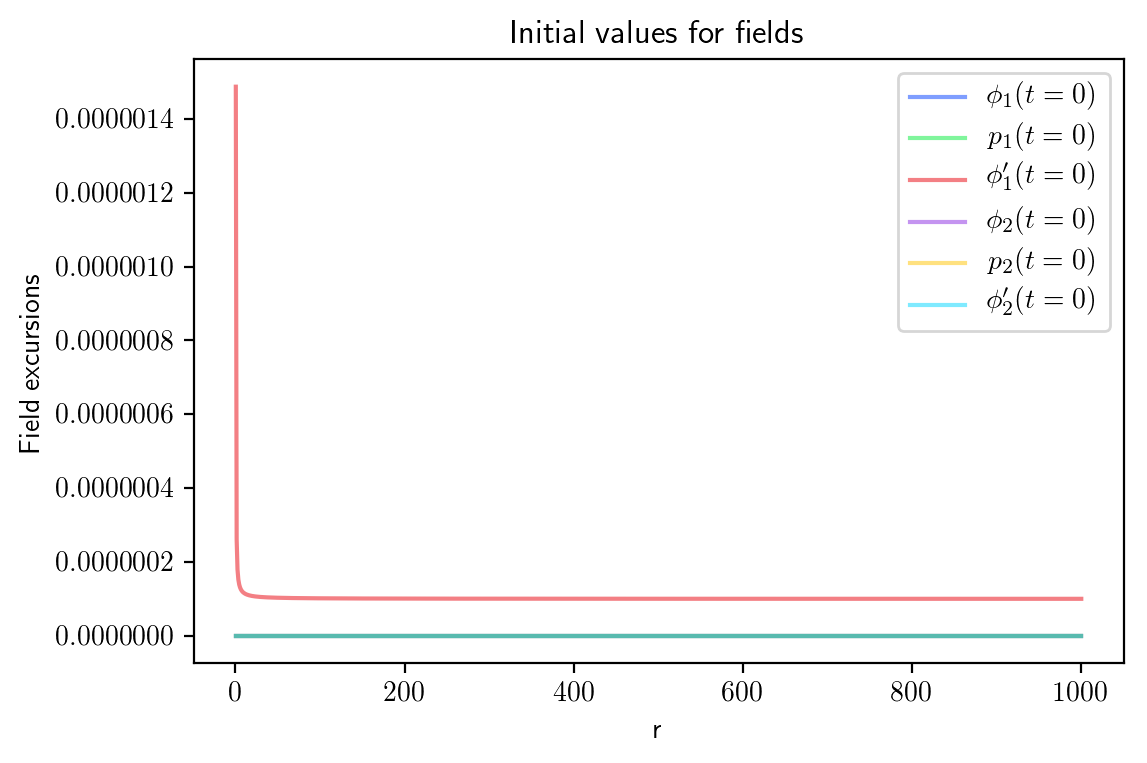

In [380]:
phi_1_init_grid = 0.*rr #epsilon_phi*(psi_s(rr)**6)/(N_s(rr)) #8.*lamb*(rr**4)/((lamb**2)+(rr**2))**4
phi_2_init_grid = 0.*rr
p_1_init_grid = 0.*rr
p_2_init_grid = 0.*rr
phi_1_dr_init_grid = epsilon_phi*(psi_s(rr)**6) #epsilon_phi*psi_r_s(rr)*(6.*(psi_s(rr)**5)/(N_s(rr)) - N_r_s(rr)*(psi_s(rr)**6)/(N_s(rr)**2))
phi_2_dr_init_grid = 0.0*rr
K_init_grid = 0.*rr
#a_init_grid = q_schwarz/(rr+m_schwarz+(m_schwarz**2 - q_schwarz**2)/(4*rr))

phi_1_init = interp_funct(rr, phi_1_init_grid)
phi_2_init = interp_funct(rr, phi_2_init_grid)
p_1_init = interp_funct(rr, p_1_init_grid)
p_2_init = interp_funct(rr, p_2_init_grid)
phi_1_dr_init = interp_funct(rr, phi_1_dr_init_grid)
phi_2_dr_init = interp_funct(rr, phi_2_dr_init_grid)
K_init = interp_funct(rr, K_init_grid)
#at_init = interp_funct(rr, at_init_grid)

plt.xlabel('r'); plt.ylabel('Field excursions'); plt.title('Initial values for fields');
plt.plot(rr, phi_1_init(rr) , label='$\phi_1(t=0)$', alpha=0.5)
plt.plot(rr, p_1_init(rr), label ='$p_1(t=0)$', alpha=0.5)
plt.plot(rr, phi_1_dr_init(rr), label ='$\phi\'_1(t=0)$', alpha=0.5)
plt.plot(rr, phi_2_init(rr) , label='$\phi_2(t=0)$', alpha=0.5)
plt.plot(rr, p_2_init(rr), label ='$p_2(t=0)$', alpha=0.5)
plt.plot(rr, phi_2_dr_init(rr), label ='$\phi\'_2(t=0)$', alpha=0.5)
#plt.plot(rr, at_init(rr), label ='$A_{t0}$', alpha=0.5)
#plt.plot(rr, chi_init_grid , label='$\chi_{0}$ grid points', alpha=0.5)
#plt.plot(rr, chi_dt_init_grid, label ='$\dot{\chi}_{0}$ grid points', alpha=0.5)
plt.legend(); plt.show()

The RN Black Hole solution in isotropic coordinates (Copson solution, 1928) which will gives the boundary condition to the metric

$\mathrm{d}s^2 = \displaystyle-\Bigg(\frac{1-\frac{M^2 - Q^2}{4r^2}}{1+\frac{M}{r}+\frac{M^2-Q^2}{4r^2}}\Bigg)^2 \mathrm{d}t^2 + \Big(1+\frac{M}{r}+\frac{M^2-Q^2}{4r^2}\Big)^2 (\mathrm{d}r^2+r^2\mathrm{d}\Omega^2)$.

The transformation between isotropic radius $r$ and the schwarzchild radius $r_{\text{sch}}$ is

$r_{\text{sch}} = r\Big( 1 + \frac{M}{r} + \frac{M^2-Q^2}{4r^2} \Big)$.

First, we set all matter fields to 0 everywhere and the gauge field to be the Coulomb's field. Then we solve the metric from $r_{\text{min}}$ using the exact metric numerical value as initial conditions. Note that the matter Lagrangian charge $C$ and the Reissner-Nordstrom charge (radius) $Q$ differ by the Newton constant

$\kappa C = \sqrt{2}Q$.

In [402]:
N_s = lambda r: 1.-m_schwarz/(2.*r)
N_r_s = lambda r: m_schwarz/(2.*r**2)
psi_s = lambda r: 1.+m_schwarz/(4.*r)
psi_r_s = lambda r: -m_schwarz/(4.*r**2)
C_s = lambda r: np.sqrt(2.)*q_schwarz*np.ones_like(r)/kap
a_r_s = lambda r: C_s(r)*(1./r - 2.*m_schwarz/r**2) 
a_s = lambda r: -C_s(r)*(1./(r**2) - m_schwarz/(r**3))

N_exact = lambda r: (1.-(m_schwarz**2 - q_schwarz**2)/(4.*r**2))/(1.+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2) )
N_r_exact = lambda r: (m_schwarz/r**2 + (m_schwarz**2 - q_schwarz**2)/r**3 + (m_schwarz/r**2)*(m_schwarz**2 - q_schwarz**2)/(4.*r**2) )/(1.+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2))**2
psi_exact = lambda r: np.sqrt(1+m_schwarz/r+(m_schwarz**2 - q_schwarz**2)/(4.*r**2))
psi_r_exact = lambda r: -((m_schwarz**2 - q_schwarz**2)/(4.*r**2) + (m_schwarz/(2.*r)))/(r*psi_s(r))
C_exact = lambda r: np.sqrt(2.)*q_schwarz*np.ones_like(r)/kap
a_r_exact = lambda r: C_s(r)*(1. - (m_schwarz**2 - q_schwarz**2)/(4*r**2))/(r*(1 + m_schwarz/r + (m_schwarz**2-q_schwarz**2)/(4*r**2)))**2 
a_exact = lambda r: -C_s(r)/(r*(1 + m_schwarz/r + (m_schwarz**2-q_schwarz**2)/(4*r**2)))


def likelihood_dist(r_b, A_b, B_b, C_b, psi_b, N_b, a_b, bounds, offsets = None):
    A_bnd = bounds[0]; B_bnd = bounds[1]; C_bnd = bounds[2];
    psi_bnd = bounds[3]; N_bnd = bounds[4]; a_bnd = bounds[5];
    if offsets is None:
        dist = ((A_b/(r_b**2))/A_bnd)**2 + (r_b*(psi_b**4)*B_b/B_bnd)**2 + (C_b/C_bnd)**2 \
                + ((psi_b-1.)/psi_bnd)**2 + ((N_b-1.)/N_bnd)**2 + ((a_b*psi_b**2/N_b)/a_bnd)**2
    else:
        A_off = offsets[0]; B_off = offsets[1]; C_off = offsets[2];
        psi_off = offsets[3]; N_off = offsets[4]; a_off = offsets[5];
        dist = ((A_b/(r_b**2) - A_off)/A_bnd)**2 + ((r_b*(psi_b**4)*B_b - B_off)/B_bnd)**2 + ((C_b - C_off)/C_bnd)**2\
                + ((psi_b - psi_off)/psi_bnd)**2 + ((N_b - N_off)/N_bnd)**2 + ((a_b - a_off)/a_bnd)**2
    return dist
    
def shoot_r(init_input, r, bounds, offsets = None, reverse = False):
    if reverse:
        r_i = r[-1]; r_f = r[0];
        ret_full = nint.solve_ivp(fun_r_solve, (r_i, r_f), init_input, method='RK45',\
                                  t_eval=r[::-1], rtol=1e-6, atol=1e-8)
    else:
        r_i = r[0]; r_f = r[-1];
        ret_full = nint.solve_ivp(fun_r_solve, (r_i, r_f), init_input, method='RK45',\
                                  t_eval=r, rtol=1e-6, atol=1e-8)
    if not ret_full.success:
        return np.inf
    A_out = ret_full.y[0]; B_out = ret_full.y[1]; C_out = ret_full.y[2];
    psi_out = ret_full.y[3]; N_out = ret_full.y[4]; a_out = ret_full.y[5];
    dist = likelihood_dist(r_f, A_out[-1], B_out[-1], C_out[-1], psi_out[-1], N_out[-1], a_out[-1], bounds, offsets)  
    return dist

The ODE system accept an input $\vec{\text{input}} = (\vec{\text{var}}; \vec{\text{aux}})$

Our variable vector to solve this 1D ODE is $\vec{\text{var}} = \begin{pmatrix} A \\ B \\ C \\ \psi \\ N \\ a  \end{pmatrix}$.

The auxiliary input is $\vec{\text{aux}} = \begin{pmatrix} v_{\text{vev}} \\ \chi_1 \\ \chi_2 \\ p_1 \\ p_2 \\ \chi_1' \\ \chi_2'  \end{pmatrix}$, which will be fully dynamical when we evolve the system in time.

First of all, let's examine the "initial guess". The default tolerance of the RK4 solver is rtol = 1e-3, atol = 1e-6.

CPU times: user 112 ms, sys: 3.7 ms, total: 116 ms
Wall time: 114 ms
number of steps of r: 1000


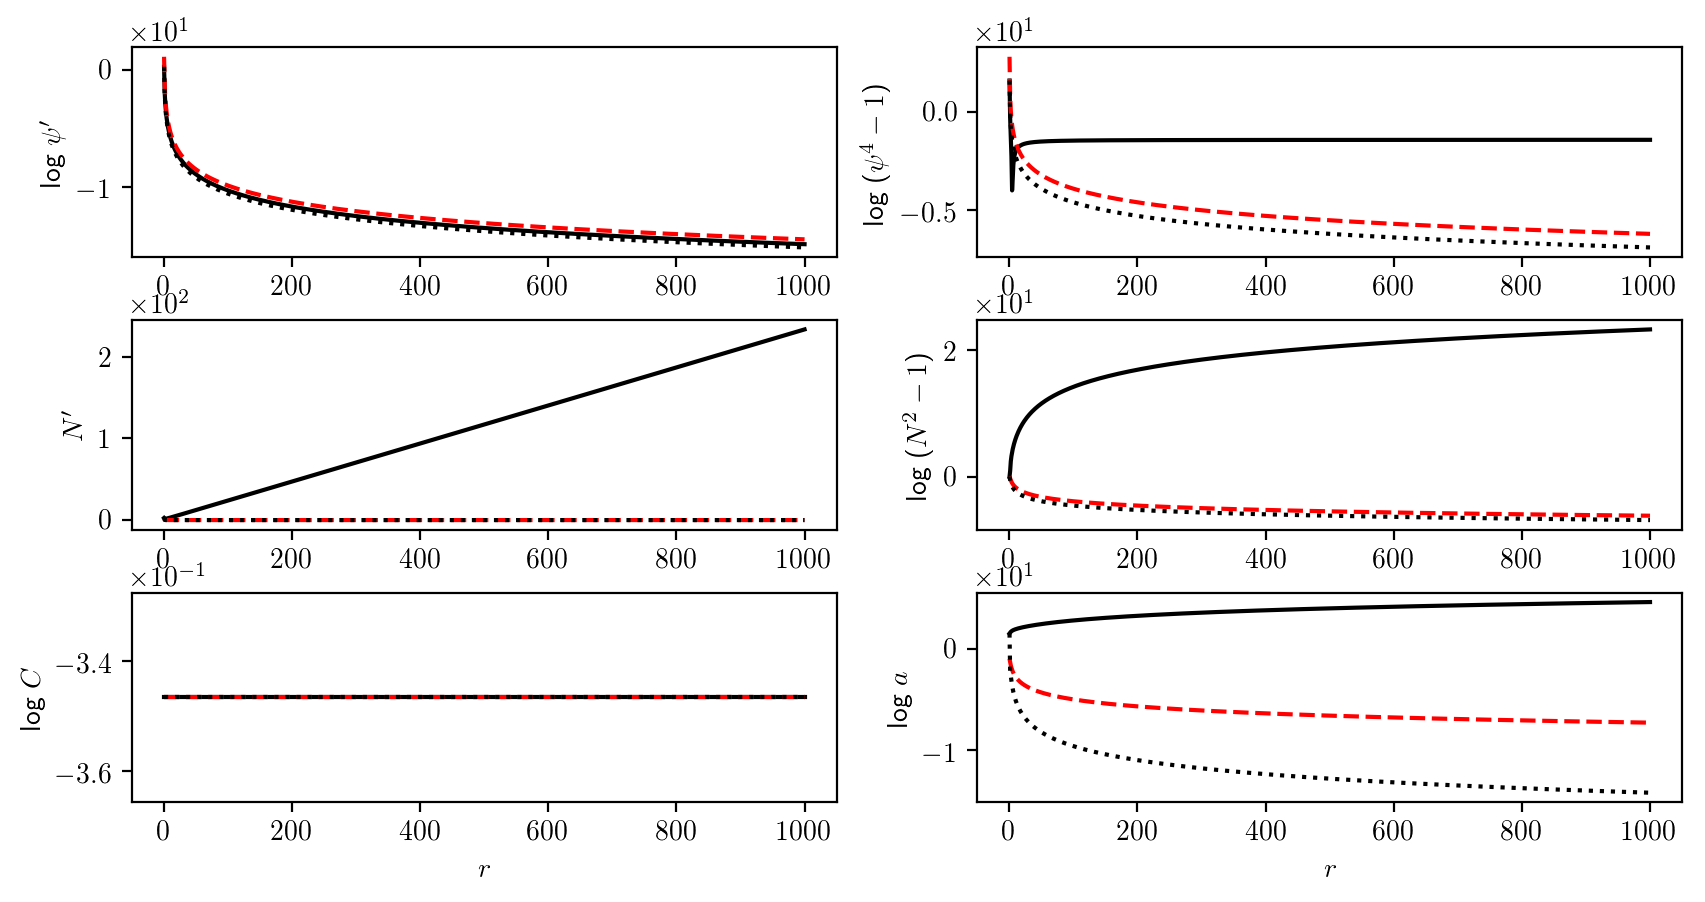

In [403]:
init_input = np.array([psi_r_s(r_min)*r_min**2, N_r_s(r_min)/(r_min*psi_s(r_min)**4), C_s(r_min), \
                       psi_s(r_min), N_s(r_min), a_s(r_min)])
r_i = rr[0]; r_f = rr[-1];


fun_r_solve = lambda r, y: fun_r(r, y, [vevsq, phi_1_init, phi_2_init, p_1_init, p_2_init, phi_1_dr_init, phi_2_dr_init, K_init])

%time ret_full = nint.solve_ivp(fun_r_solve, (r_i,r_f), init_input, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-6)
if not ret_full.success: print "INTEGRATION FAILED!"
    
A_out = ret_full.y[0]; B_out = ret_full.y[1]; C_out = ret_full.y[2];
psi_out = ret_full.y[3]; N_out = ret_full.y[4]; a_out = ret_full.y[5]

print "number of steps of r: "+ str(len(ret_full.t))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[0,0].plot(ret_full.t, logit(A_out/(ret_full.t**2)), label='$A$',color='black'); ax[0,0].set_ylabel('log $\psi\'$');
ax[1,0].plot(ret_full.t, ret_full.t*B_out*(psi_out**4), label='$B$',color='black'); ax[1,0].set_ylabel('$N\'$')
ax[0,1].plot(ret_full.t, logit(psi_out**4-1.), label='$\psi$',color='black'); ax[0,1].set_ylabel('log ($\psi^4 - 1$)')
ax[1,1].plot(ret_full.t, logit(N_out**2-1.), label='$N$',color='black'); ax[1,1].set_ylabel('log ($N^2 - 1$)')
ax[2,0].plot(ret_full.t, logit(C_out), label='$C$',color='black'); ax[2,0].set_ylabel('log $C$')
ax[2,1].plot(ret_full.t, logit(a_out), label='$a$',color='black'); ax[2,1].set_ylabel('log $a$')

ax[0,0].plot(ret_full.t, logit(psi_r_exact(ret_full.t)), label='$A$',color='red', linestyle='--'); 
ax[1,0].plot(ret_full.t, N_r_exact(ret_full.t), label='$B$',color='red', linestyle='--'); 
ax[0,1].plot(ret_full.t, logit(psi_exact(ret_full.t)**4-1.), label='$\psi$',color='red', linestyle='--'); 
ax[1,1].plot(ret_full.t, logit(N_exact(ret_full.t)**2-1.), label='$N$',color='red', linestyle='--'); 
ax[2,0].plot(ret_full.t, logit(C_exact(ret_full.t)), label='$C$',color='red', linestyle='--');
ax[2,1].plot(ret_full.t, logit(a_exact(ret_full.t)), label='$a$',color='red', linestyle='--');

ax[0,0].plot(ret_full.t, logit(psi_r_s(ret_full.t)), label='$A$',color='black', linestyle=':'); 
ax[1,0].plot(ret_full.t, N_r_s(ret_full.t), label='$B$',color='black', linestyle=':'); 
ax[0,1].plot(ret_full.t, logit(psi_s(ret_full.t)**4-1.), label='$\psi$',color='black', linestyle=':'); 
ax[1,1].plot(ret_full.t, logit(N_s(ret_full.t)**2-1.), label='$N$',color='black', linestyle=':'); 
ax[2,0].plot(ret_full.t, logit(C_s(ret_full.t)), label='$C$',color='black', linestyle=':');
ax[2,1].plot(ret_full.t, logit(a_s(ret_full.t)), label='$a$',color='black', linestyle=':');

plt.show()

In [ ]:
reverse_bnd = False

if not reverse_bnd:
    offs = [psi_r_s(r_max), N_r_s(r_max), C_s(r_max), psi_s(r_max), N_s(r_max), a_s(r_max)]
    bnd_dnf = lambda n: rr[-1]**n
    #bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]
    bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), bnd_dnf(0.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.), bnd_dnf(-1.)]
else:
    offs = [psi_r_s(r_min), N_r_s(r_min), C_s(r_min), psi_s(r_min), N_s(r_min), a_s(r_min)]
    bnd_dnf = lambda n: rr[0]**n
    bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.)]

if not reverse_bnd:
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
else:
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
if result["success"]:
    print("Success!")
    
x_return = result["x"]
print("The optimized inital values are: " + str(x_return))
print("The result distance is: " + str(result["fun"]))

if not reverse_bnd:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_min , r_max), x_return, method='RK45', t_eval=rr, rtol=1e-5, atol=1e-5)
else:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_max , r_min), x_return, method='RK45', t_eval=rr[::-1], rtol=1e-5, atol=1e-5)
A_out = ret_full.y[0]; B_out = ret_full.y[1];  C_out = ret_full.y[2];
psi_out = ret_full.y[3]; N_out = ret_full.y[4]; a_out = ret_full.y[5];

A_init = interp_funct(ret_full.t, A_out); B_init = interp_funct(ret_full.t, B_out);
psi_init = interp_funct(ret_full.t, psi_out); N_init = interp_funct(ret_full.t, N_out);
a_init = interp_funct(ret_full.t, a_out); C_init = interp_funct(ret_full.t, C_out)

We now run the RK4 ODE-solver in full.

We use the shooting method from $r \simeq 0$ to $r = R \gg 1$. Our target at $R$ is the flat space metric. Our uncertainty in the boundary metric from $R\neq \infty$ is due to the Schwarzchild component of the matter field, namely,

$N = \displaystyle\frac{1-\frac{M}{2R}}{1+\frac{M}{2R}} \approx 1-\frac{M}{R}+ O(\frac{1}{R^2})$,

$\psi = 1+\frac{M}{2R}$,

$N' = \displaystyle\frac{M}{(1+\frac{M}{2R^2})R^2} \approx \frac{M}{R^2}+ O(\frac{1}{R^3})$

$\psi' = - \frac{M}{2 R^2}$

which gives the uncertainty $(N-1) \approx (\psi-1) \sim O\Big(\frac{1}{R}\Big)$ and their derivatives $N' \approx \psi' \sim O\Big(\frac{1}{R^2}\Big)$.

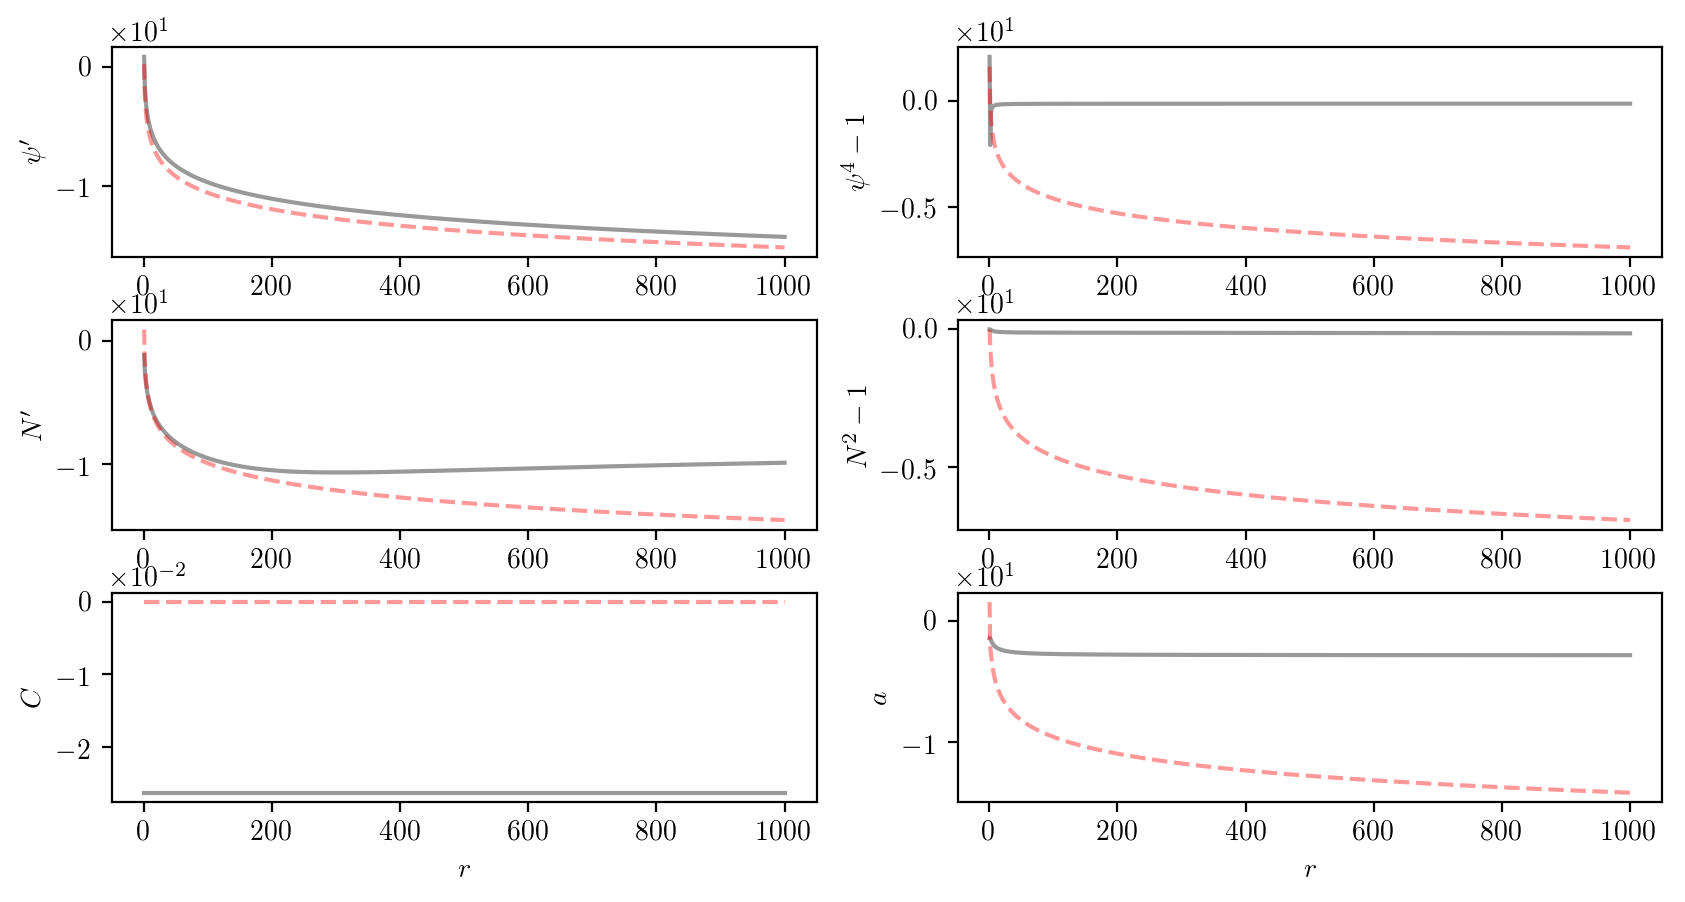

In [384]:
r_i = rr[0]; r_f = rr[-1];

c_matter = np.sqrt(2)*q_schwarz/kap

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
ax[0,0].plot(ret_full.t, logit(A_out/(ret_full.t**2)), label='$psip$',color='black', alpha=0.4); ax[0,0].set_ylabel('$\psi\'$');
ax[0,0].plot(ret_full.t, logit(psi_r_s(ret_full.t)), label='$psipBH$',color='red', linestyle='--',alpha=0.4);

ax[1,0].plot(ret_full.t, logit(ret_full.t*B_out*(psi_out**4)), label='$Np$',color='black', alpha=0.4); ax[1,0].set_ylabel('$N\'$');
ax[1,0].plot(ret_full.t, logit(N_r_s(ret_full.t)), label='$NpBH$',color='red', linestyle='--',alpha=0.4);

ax[0,1].plot(ret_full.t, logit(psi_out**4-1.), label='$\psi$',color='black', alpha=0.4); ax[0,1].set_ylabel('$\psi^4 - 1$');
ax[0,1].plot(ret_full.t, logit(psi_s(ret_full.t)**4-1.), label='$\psiBH$',color='red', linestyle='--', alpha=0.4);

ax[1,1].plot(ret_full.t, logit(N_out**2-1.), label='$N$',color='black', alpha=0.4); ax[1,1].set_ylabel('$N^2 - 1$');
ax[1,1].plot(ret_full.t, logit(N_s(ret_full.t)**2-1.), label='$NBH$',color='red' , linestyle='--',alpha=0.4); 

ax[2,0].plot(ret_full.t, C_out-c_matter, label='$C$',color='black', alpha=0.4); ax[2,0].set_ylabel('$C$');
ax[2,0].plot(ret_full.t, C_s(ret_full.t)-c_matter, label='$CBH$',color='red' , linestyle='--',alpha=0.4); 

ax[2,1].plot(ret_full.t, logit(a_out), label='$a$',color='black', alpha=0.4); ax[2,1].set_ylabel('$a$');
ax[2,1].plot(ret_full.t, logit(a_s(ret_full.t)), label='$aBH$',color='red' , linestyle='--',alpha=0.4);

plt.show()

## Time evolution

We will use Eq.(1),(2),(3),(5) to evolve $\phi$, $p$, $\psi$ and $K$ the time forwards.

We need to evolve the spatial curvature $K=-\frac{6\dot{\psi}}{N\psi}$, and the matter fields $\chi$, $p$ temporally.

$\dot{\Phi} = \frac{N}{\psi^6}p - iqa\Phi$,

$\quad\left\{\begin{matrix} \dot{\phi}_1 = \frac{N}{\psi^6}p_1 + qa\phi_2 \\ \\ \dot{\phi}_2 = \frac{N}{\psi^6}p_2 - qa\phi_1\end{matrix}\right.$

$\dot{p} = \frac{2}{r}N\psi^2\Phi' + r\psi^6 B\Phi' +\frac{2}{r^2}N\psi A\Phi' + 2N\psi^2\Phi''-\lambda \psi^6 N\Phi^*(|\Phi|^2-v^2) -iqap$

$\quad\left\{\begin{matrix} \dot{p}_1 =  \frac{2}{r}N\psi^2\phi_1' + r\psi^6 B\phi_1' +\frac{2}{r^2}N\psi A\phi_1' + N\psi^2\phi_1'' - \lambda\psi^6 N\phi_1(\phi_1^2+\phi_2^2-2v^2) + qap_2 \\ \\ \dot{p}_2 = \frac{2}{r}N\psi^2\phi_2' + r\psi^6 B\phi_2' +\frac{2}{r^2}N\psi A\phi_2' + N\psi^2\phi_2'' + \lambda\psi^6 N\phi_2(\phi_1^2+\phi_2^2-2v^2) - qap_1\end{matrix}\right.$

$a' = \frac{N}{\psi^2}g, \qquad \qquad g = \frac{C}{r^2}$,

$\dot{g} = qN\psi^2(\phi_1 \phi_2' - \phi_1'\phi_2) $,

$\frac{\dot{K}}{N} = \frac{K^2}{2}-\frac{6A}{r^3\psi^5}\Big(\frac{A}{r\psi}+1\Big) - \frac{3B}{N} \Big(\frac{2A}{r\psi} + 1\Big) -\frac{3\kappa^2}{4}\Big(\frac{\phi_1'^2 + \phi_2'^2}{\psi^4} + \frac{p_1^2 + p_2^2}{\psi^{12}} - \frac{g^2}{\psi^8} - \frac{\lambda}{2}(\phi_1^2 + \phi_2^2 - 2v^2)^2\Big)$.

In [305]:
def dphi_1_dt(N, psi, phi_2, a, p_1):
    phi_1_t = N*p_1/(psi**6) + q*a*phi_2
    return phi_1_t

def dphi_2_dt(N, psi, phi_1, a, p_2):
    phi_2_t = N*p_2/(psi**6) - q*a*phi_1
    return phi_2_t

def dp_1_dt(r, N, psi, phi_1, phi_2, a, p_2, A, B, phi_1_r, phi_1_rr, vevsq):
    p_1_t = 2.*N*(psi**2)*phi_1_r/r + r*(psi**6)*B*phi_1_r + 2.*N*psi*A*phi_1_r/r**2 + N*(psi**2)*phi_1_rr\
        - lamb*(psi**6)*N*phi_1*(phi_1**2+phi_2**2-2.*vevsq) + q*a*p_2
    return p_1_t

def dp_2_dt(r, N, psi, phi_1, phi_2, a, p_1, A, B, phi_2_r, phi_2_rr, vevsq):
    p_2_t = 2.*N*(psi**2)*phi_2_r/r + r*(psi**6)*B*phi_2_r + 2.*N*psi*A*phi_2_r/r**2 + N*(psi**2)*phi_2_rr\
        + lamb*(psi**6)*N*phi_2*(phi_1**2+phi_2**2-2.*vevsq) - q*a*p_1
    return p_2_t

def dg_dt(N, psi, phi_1, phi_2, phi_1_r, phi_2_r):
    g_t = q*N*(psi**2)*(phi_1*phi_2_r - phi_1_r*phi_2)
    return g_t

def dpsi_dt(N, K, psi):
    psi_t = -N*psi*K/6.
    return psi_t

def dK_dt(r, N, A, B, K, psi, phi_1, phi_2, p_1, p_2, g, phi_1_r, phi_2_r, vevsq):
    K_t = N*(K**2)/2. - 6.*N*A**2/((r**4)*(psi**6)) - 6.*N*A/((r**3)*(psi**5)) - 6*A*B/(r*psi) - 3*B \
        + (3.*kapsq/4.)*N*( (phi_1_r**2 + phi_2_r**2)/psi**4 + (p_1**2 + p_2**2)/(psi**12) \
        - g**2/psi**8 - (lamb/2.)*(phi_1**2 + phi_2**2 - 2.*vevsq)**2 )
    return K_t

#def K_fun(N, psi, psi_dt):
#    return -6*psi_dt/(N*psi)

#def N_fun(K, psi, psi_dt):
#    return -6*psi_dt/(K*psi)

We use the foward differencing method for a grid with grid size $\Delta x$. We use forward differencing method because it is much easier to find the asymptotic boundary for $N(r)$, $\psi(r)$ and their derivatives at  $ r = r_{\text{max}}$, then to find those near the horizon ($r = r_h$). 

$\displaystyle\frac{\mathrm{d}{f}}{\mathrm{d}x} = \frac{f(x+\Delta x) - f(x)}{\Delta x} + O(\Delta x^2)$

$\displaystyle\frac{\mathrm{d}^2{f}}{\mathrm{d}x^2} = \frac{-f(x+3\Delta x)+4f(x+2\Delta x)-5f(x+\Delta x)+2f(x)}{\Delta x^2} + O(\Delta x^2)$

Note that in the last equation, we need $f(x+3\Delta x)$ in order to achieve $O(\Delta x^2)$ precision for forward differencing.

In [306]:
def df_dx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x
    if n_bnd is None:
        f_dx = (f(x_plus) - f(x))/delta_x
    else:
        f_dx = (f(x_plus[:-1]) - f(x[:-1]))/delta_x
        f_bnd = f_dx[-1]*(x_plus[-1]/x[-1])**(n_bnd-1)
        f_dx = np.hstack((f_dx, f_bnd))
    return f_dx

def ddf_dxdx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x; x_plus_2 = x + 2*delta_x; x_plus_3 = x + 3*delta_x
    if n_bnd is None:
        f_dxdx = (2.*f(x) -5.*f(x_plus) + 4.*f(x_plus_2) - f(x_plus_3))/(delta_x**2)    
    else:   
        f_dxdx = ( 2*f(x[:-3]) - 5.*f(x_plus[:-3]) + 4.*f(x_plus_2[:-3]) - f(x_plus_3[:-3]) )/(delta_x**2)
        f_bnd_1 = (f_dxdx[-1])*(x_plus[-1]/x[-1])**(n_bnd-2)
        f_bnd_2 = (f_dxdx[-1])*(x_plus_2[-1]/x[-1])**(n_bnd-2)
        f_bnd_3 = (f_dxdx[-1])*(x_plus_3[-1]/x[-1])**(n_bnd-2)
        f_dxdx = np.hstack(( f_dxdx, f_bnd_1, f_bnd_2, f_bnd_3 ))
    return f_dxdx

We first extract the ODE result at $t=0$ in the **One dimensional radial action** section. We need to transfer the ODEint grid to our custom grid through smooth function interpolation.

In [307]:
phi_1_dr_grid = df_dx(rr, phi_1_init)
phi_1_drdr_grid = ddf_dxdx(rr, phi_1_init)
phi_2_dr_grid = df_dx(rr, phi_2_init)
phi_2_drdr_grid = ddf_dxdx(rr, phi_2_init)

K_grid = 0.*rr; #-6*psi_grid_out_dt/(N_grid_out_init*psi_grid_out_init)

phi_1_grid = phi_1_init(rr); phi_2_grid = phi_2_init(rr)
p_1_grid = p_1_init(rr); p_2_grid = p_2_init(rr)

A_grid = A_init(rr); B_grid = B_init(rr); g_grid = C_init(rr)/(rr**2);
psi_grid = psi_init(rr); N_grid = N_init(rr); a_grid = a_init(rr);

Evolve the system in time. The time evolution vector is
$\vec{\text{var}} = \begin{pmatrix} \phi_1 \\ \phi_2 \\ p_1 \\ p_2 \\ a \\ g \\ K \end{pmatrix}$.

We can use

$\frac{K'}{3} = \frac{\kappa^2}{2\psi^6}\chi'p$

and

$K=-\frac{6\dot{\psi}}{N\psi}$

to check for the consistency of the evolution of $K$.

They are two running mode. The default run mode (not reverse) takes the ODE-input at $r = r_{\rm min}$ and constraint the ODE boundary at $r = r_{\rm max}$. The ODE system is integrate forward, in increasing $r$. The reverse mod takes the ODE-input at $r = r_{\rm max}$ and constraint the ODE boundary at $r = r_{\rm min}$. The ODE system is integrate backward, in decreasing $r$.

In [308]:
bnd_dnf = lambda n: rr[-1]**n
reverse_bnd = False

def fun_t(r, y, dt, t=None, verbose=False):
    
    A_f_in = y[0]; B_f_in = y[1];  C_f_in = y[2];
    psi_f_in = y[3]; N_f_in = y[4]; a_f_in = y[5];
    vevsq_f_in = y[6]; phi_1_f_in = y[7]; phi_2_f_in = y[8];
    p_1_f_in = y[9]; p_2_f_in = y[10]; phi_1_dr_f_in = y[11];
    phi_2_dr_f_in = y[12]; K_f_in = y[13];
    
    vevsq_f_out = vevsq_f_in
    
    phi_1_drdr_in = ddf_dxdx(r, phi_1_f_in, -5)
    phi_2_drdr_in = ddf_dxdx(r, phi_2_f_in, -5)
    
    A_grid_in = A_f_in(r)
    N_grid_in = N_f_in(r)
    B_grid_in = B_f_in(r)
    C_grid_in = C_f_in(r)
    psi_grid_in = psi_f_in(r)
    a_grid_in = a_f_in(r)
    vevsq_grid_in = vevsq_f_in(r)
    phi_1_grid_in = phi_1_f_in(r); phi_1_dr_grid_in = phi_1_dr_f_in(r)
    phi_2_grid_in = phi_2_f_in(r); phi_2_dr_grid_in = phi_2_dr_f_in(r)
    p_1_grid_in = p_1_f_in(r)
    p_2_grid_in = p_2_f_in(r)
    K_grid_in = K_f_in(r)
    g_grid_in = C_f_in(r)/(r**2)
    
    phi_1_dt = dphi_1_dt(N_grid_in, psi_grid_in, phi_2_grid_in, a_grid_in, p_1_grid_in) 
    phi_2_dt = dphi_2_dt(N_grid_in, psi_grid_in, phi_1_grid_in, a_grid_in, p_2_grid_in) 
    p_1_dt = dp_1_dt(r, N_grid_in, psi_grid_in, phi_1_grid_in, phi_2_grid_in, a_grid_in, p_2_grid_in,\
               A_grid_in, B_grid_in, phi_1_dr_grid_in, phi_1_drdr_grid, vevsq_grid_in)
    p_2_dt = dp_2_dt(r, N_grid_in, psi_grid_in, phi_1_grid_in, phi_2_grid_in, a_grid_in, p_1_grid_in,\
               A_grid_in, B_grid_in, phi_2_dr_grid_in, phi_2_drdr_in, vevsq_grid_in)
    g_dt = dg_dt(N_grid_in, psi_grid_in, phi_1_grid_in, phi_2_grid_in, phi_1_dr_grid_in, phi_2_dr_grid_in)
    K_dt = dK_dt(r, N_grid_in, A_grid_in, B_grid_in, K_grid_in, psi_grid_in, phi_1_grid_in, phi_2_grid_in, \
             p_1_grid_in, p_2_grid_in, g_grid_in, phi_1_dr_grid_in, phi_2_dr_grid_in, vevsq_grid_in)
    phi_1_out = phi_1_grid_in + phi_1_dt*dt
    phi_2_out = phi_2_grid_in + phi_2_dt*dt
    p_1_out = p_1_grid_in + p_1_dt*dt
    p_2_out = p_2_grid_in + p_2_dt*dt
    g_out = g_grid_in + g_dt*dt
    K_out = K_grid_in + K_dt*dt
    
    phi_1_f_out = interp_funct(r, phi_1_out)
    phi_1_dr_out = df_dx(r, phi_1_f_out, -4.)
    phi_2_f_out = interp_funct(r, phi_2_out)
    phi_2_dr_out = df_dx(r, phi_2_f_out, -4.)

    phi_1_dr_f_out = interp_funct(r, phi_1_dr_out)
    phi_2_dr_f_out = interp_funct(r, phi_2_dr_out)
    p_1_f_out = interp_funct(r, p_1_out)
    p_2_f_out = interp_funct(r, p_2_out)
    C_f_out = interp_funct(r, g_out*(r**2))
    K_f_out = interp_funct(r, K_out)

    fun_r_solve = lambda r, y: fun_r(r, metric_input, aux_input)
 
    if not reverse_bnd:
        aux_input = [vevsq_f_in(r[0]), phi_1_f_in, phi_2_f_in, p_1_f_in, p_2_f_in,\
                      phi_1_dr_f_in, phi_2_dr_f_in, K_f_in]
        metric_input = [A_f_in(r[0]), B_f_in(r[0]), C_f_in(r[0]), psi_f_in(r[0]), N_f_in(r[0]), a_f_in(r[0])]
        offs = [psi_r_s( r[-1] ), N_r_s( r[-1] ), C_s( r[-1] ), psi_s( r[-1] ), N_s( r[-1] ), a_s( r[-1] )]
        bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), bnd_dnf(0.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.), bnd_dnf(-1.)]
        result = opt.minimize(shoot_r, init_input, args=(r, bnds, offs), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
    else:
        aux_input = [vevsq_f_in(r[-1]), phi_1_f_in, phi_2_f_in, p_1_f_in, p_2_f_in,\
                      phi_1_dr_f_in, phi_2_dr_f_in, K_f_in]
        metric_input = [A_f_in(r[-1]), B_f_in(r[-1]), C_f_in(r[-1]), psi_f_in(r[-1]), N_f_in(r[-1]), a_f_in(r[-1])]
        offs = [psi_r_s( r[0] ), N_r_s( r[0] ), C_s( r[0] ), psi_s( r[0] ), N_s( r[0] ), a_s( r[0] )]
        bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.)]
        result = opt.minimize(shoot_r, init_input, args=(r, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})

    if not result["success"]:
        print("Error: Minimizer failed!")
        return False

    A_out = ret_full.y[0]; B_out = ret_full.y[1]; C_out = ret_full.y[2];
    psi_out = ret_full.y[3]; N_out = ret_full.y[4]; a_out = ret_full.y[5];
    
    if verbose:
        print("The optimized inital values are: " + str(x_return))
        print("The result distance is: " + str(result["fun"]))
        print("Values at boundary is: " + str([A_out[-1], B_out[-1], psi_out[-1], N_out[-1], a_out[-1], C_out[-1]]) )
        
    A_f_out = interp_funct(ret_full.t, A_out)
    B_f_out = interp_funct(ret_full.t, B_out)
    #C_f_out = interp_funct(ret_full.t, C_out)
    psi_f_out = interp_funct(ret_full.t, psi_out)
    N_f_out = interp_funct(ret_full.t, N_out)
    a_f_out = interp_funct(ret_full.t, a_out)

    #vevsq_f_out = interp_funct( ret_full.t, vevsq_const_out*np.ones_like(ret_full.t) )
    
    return [A_f_out, B_f_out, C_f_out, psi_f_out, N_f_out, a_f_out, vevsq_f_out, \
            phi_1_f_out, phi_2_f_out, p_1_f_out, p_2_f_out, phi_1_dr_f_out, phi_2_dr_f_out, K_f_out]

In [309]:
if not reverse_bnd:
    offs = [psi_r_s(r_max), N_r_s(r_max), C_s(r_max), psi_s(r_max), N_s(r_max), a_s(r_max)]
    bnd_dnf = lambda n: rr[-1]**n
    bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), bnd_dnf(0.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.), bnd_dnf(-1.)]
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
else:
    offs = [psi_r_s(r_min), N_r_s(r_min), C_s(r_min), psi_s(r_min), N_s(r_min), a_s(r_min)]
    bnd_dnf = lambda n: rr[0]**n
    bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.), bnd_dnf(0.)]
    
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
    
if result["success"]:
    print("Success!")
    
x_return = result["x"]
print("The optimized inital values are: " + str(x_return))
print("The result distance is: " + str(result["fun"]))

if not reverse_bnd:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_min , r_max), x_return, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-8)
else:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_max , r_min), x_return, method='RK45', t_eval=rr[::-1], rtol=1e-6, atol=1e-8)
A_out = ret_full.y[0]; B_out = ret_full.y[1];  C_out = ret_full.y[2];
psi_out = ret_full.y[3]; N_out = ret_full.y[4]; a_out = ret_full.y[5];

A_init = interp_funct(ret_full.t, A_out); B_init = interp_funct(ret_full.t, B_out);
psi_init = interp_funct(ret_full.t, psi_out); N_init = interp_funct(ret_full.t, N_out);
a_init = interp_funct(ret_full.t, a_out); C_init = interp_funct(ret_full.t, C_out)

print("Values at boundary is: " + str([A_init(rr[-1]), B_init(rr[-1]), psi_init(rr[-1]), N_init(rr[-1]), a_init(rr[-1]), C_init(rr[-1])]) )

vevsq_init = interp_funct(rr, vevsq*np.ones_like(rr))

CPU times: user 1min 14s, sys: 74.6 ms, total: 1min 14s
Wall time: 1min 14s
Success!
The optimized inital values are: [-0.44970685  0.13326144  0.70710664  2.05942201  0.00742906 -0.37891483]
The result distance is: 6.25726137255e-14
CPU times: user 81.3 ms, sys: 5.01 ms, total: 86.3 ms
Wall time: 82.4 ms
Values at boundary is: [array(-0.4987683864044467), array(7.499973057556207e-06), array(1.0099876234931282), array(0.9802465504870028), array(-0.013863819447741732), array(0.7071066366767058)]


Running the result for *t_end* amount of time in *dt* time steps.

In [310]:
tend = 5.*1e-1

indx_vevsq = 6

vec_t = [A_init, B_init, C_init, psi_init, N_init, a_init, vevsq_init, phi_1_init, phi_2_init, \
         p_1_init, p_2_init, phi_1_dr_init, phi_2_dr_init, K_init]
t_all = np.array(vec_t)
t_size = np.array([0.])
t_now = t_size[-1]

dt_0 =5.*1e-4;

for t_step in tqdm(range(int(tend/dt_0))):
    dt = dt_0
    mphi = 1./(0.1*tend)
    vev_f_old_grid = (vec_t[indx_vevsq])(rr)
    vev_f_new_grid = vev_f_old_grid #+ (mphi*dt_0)**2
    vec_t[indx_vevsq] = interp_funct(rr, vev_f_new_grid)
    t_now = t_size[-1]+dt
    vec_t = fun_t(rr, vec_t, dt, t_now)
    t_all = np.vstack((t_all, vec_t))
    t_size = np.hstack((t_size, t_now))


100%|██████████| 1000/1000 [20:56:57<00:00, 75.42s/it]  


Using dt=1e-4, noise starts to build up in $p$ at t = 1.5e-3.
Using dt=1e-5, noise starts to build up in $p$ at t = 1e-3.

Plotting the result

In [334]:
plot_alpha = 0.7

def plot_t_slice_fields(t_all, t_slices, r, log=False):
    result = t_all[t_slices]

    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    A_result = result[:,0]; B_result = result[:,1]; C_result = result[:,2];
    psi_result = result[:,3]; N_result = result[:,4]; a_result = result[:,5];
    vev_end = result[:,6];
    phi_1_result = result[:,7]; phi_2_result = result[:,8];
    p_1_result = result[:,9]; p_2_result = result[:,10];
    phi_1_dr_result = result[:,11]; phi_2_dr_result = result[:,12];
    K_result = result[:,13]

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.5)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,0].plot(r, logit(phi_1_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[0,0].plot(r, phi_1_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$\phi_1$'); #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            phi_1_dr_grid_num = logit( df_dx(r, phi_1_result[i]) )
        else:
            phi_1_dr_grid_num = df_dx(r, phi_1_result[i])
        ax[0,1].plot(r, phi_1_dr_grid_num, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,1].set_ylabel('$\phi_1\'$ (numeric)'); #ax[0,1].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,1].plot(r, logit(phi_1_dr_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,1].plot(r, phi_1_dr_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$\phi_1\'$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,0].plot(r, logit(p_1_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,0].plot(r, p_1_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$p_1$'); #ax[1,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,0].plot(r, logit(phi_2_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,0].plot(r, phi_2_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$\phi_2$'); #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            phi_2_dr_grid_num = logit(df_dx(r, phi_2_result[i]))
        else:
            phi_2_dr_grid_num = df_dx(r, phi_2_result[i])
        ax[2,1].plot(r, phi_2_dr_grid_num, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('$\phi_2\'$ (numeric)'); #ax[0,1].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[3,1].plot(r, logit(phi_2_dr_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[3,1].plot(r, phi_2_dr_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[3,1].set_ylabel('$\phi_2\'$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[3,0].plot(r, logit(p_2_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[3,0].plot(r, p_2_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[3,0].set_ylabel('$p_2$'); #ax[1,0].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[4,0].plot(r, logit(vev_end[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[4,0].plot(r, vev_end[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[4,0].set_ylabel('$v^2$'); #ax[1,0].legend();


    print("Matter field contents")
    plt.show()

def plot_t_slice_metric(t_all, t_slices, r, log=False):
    result = t_all[t_slices]
    
    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    A_result = result[:,0]; B_result = result[:,1]; C_result = result[:,2];
    psi_result = result[:,3]; N_result = result[:,4]; a_result = result[:,5];
    vev_end = result[:,6];
    phi_1_result = result[:,7]; phi_2_result = result[:,8];
    p_1_result = result[:,9]; p_2_result = result[:,10];
    phi_1_dr_result = result[:,11]; phi_2_dr_result = result[:,12];
    K_result = result[:,13]
    
    print("Metric contents")

    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.5)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,0].plot(r, logit(A_result[i](r)/(r**2)), label=('t = ' + str(t_slice)),color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[0,0].plot(r, logit(psi_r_s(r)),linestyle = "dashed")
        else:
            ax[0,0].plot(r, A_result[i](r)/(r**2), label=('t = ' + str(t_slice)),color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[0,0].plot(r, psi_r_s(r),linestyle = "dashed")
    ax[0,0].set_ylabel('$\psi$\'');  #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,1].plot(r, logit(r*B_result[i](r)*(psi_result[i](r)**4)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[0,1].plot(r, logit(N_r_s(r)),linestyle = "dashed")
        else:
            ax[0,1].plot(r, r*B_result[i](r)*(psi_result[i](r)**4), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[0,1].plot(r, N_r_s(r),linestyle = "dashed")
    ax[0,1].set_ylabel('$N$\'');  #ax[0,1].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,0].plot(r, logit(psi_result[i](r)**4-1), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[1,0].plot(r, logit(psi_s(r)**4-1), linestyle = "dashed")
        else:
            ax[1,0].plot(r, psi_result[i](r)**4-1, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[1,0].plot(r, psi_s(r)**4-1,linestyle = "dashed")
    ax[1,0].set_ylabel('$\psi^4-1$'); #ax[1,0].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,1].plot(r, logit(N_result[i](r)**2-1.), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[1,1].plot(r, logit(N_s(r)**2-1.),linestyle = "dashed")
        else:
            ax[1,1].plot(r, N_result[i](r)**2-1., label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
            ax[1,1].plot(r, N_s(r)**2-1.,linestyle = "dashed")
    ax[1,1].set_ylabel('$N^2-1$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        ax[2,0].plot(r, K_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$K$'); #ax[2,0].legend();
    
    """for i, t_slice in enumerate(t_slices):
        if t_slice == 0: continue
        dpsi_result_dt = (psi_result[i](r)-psi_result[i-1](r))/dt
        ax[2,1].plot(r, -6.*dpsi_result_dt/(N_result[i](r)*psi_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('$K$ Numeric'); #ax[2,1].legend();"""
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,1].plot(r, logit(ddf_dxdx(r, psi_result[i], -1.)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,1].plot(r, ddf_dxdx(r, psi_result[i], -1.), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('$\psi$\" Numeric')
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[3,0].plot(r, logit(C_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[3,0].plot(r, C_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[3,0].set_ylabel('$C$');
    
    for i, t_slice in enumerate(t_slices):
        if log:
           ax[3,1].plot(r, logit(a_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha) 
        else:
            ax[3,1].plot(r, a_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[3,1].set_ylabel('$a$');
    
    plt.show()
    return

('length of time steps: ', 1001)
Matter field contents


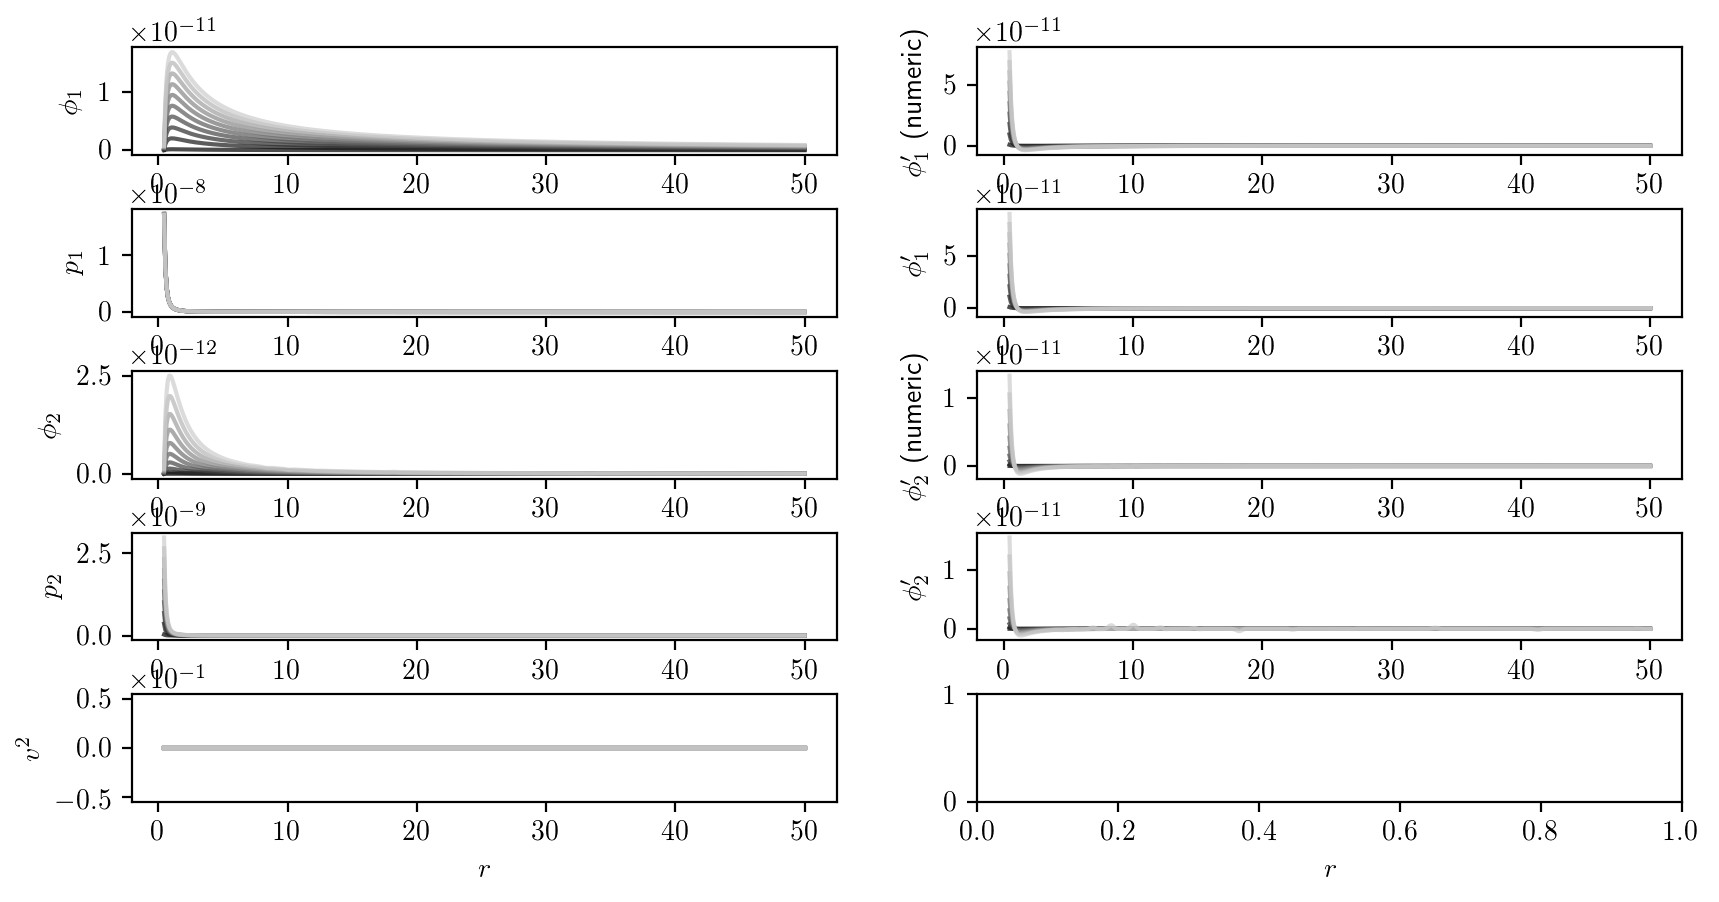

Metric contents


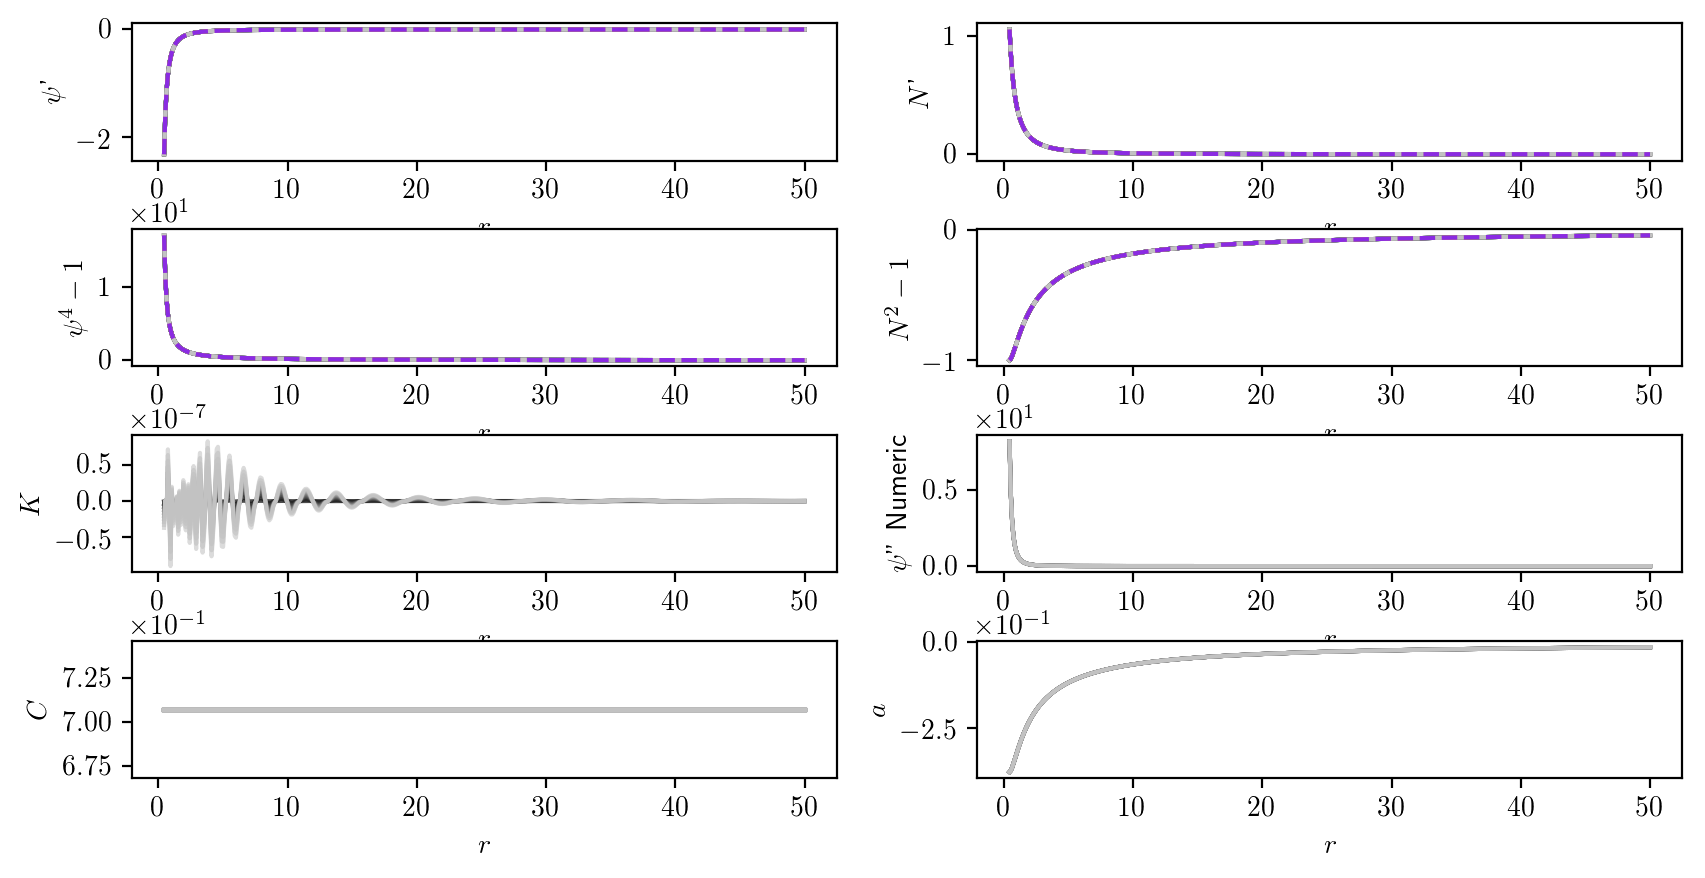

In [335]:
r_min_plot = r_min
r_max_plot = r_max

rr_plot = np.linspace(r_min_plot, r_max_plot, 500)
time_range = range(10,1000,100)

print("length of time steps: ", len(t_all))
plot_t_slice_fields(t_all, time_range, rr_plot, log=False)
plot_t_slice_metric(t_all, time_range, rr_plot, log=False)
#plot_t_slice([1,1000],rr_plot)

In [313]:
save_file = "/Users/john/Desktop/AbelianNotes/bh_no_vev_result.csv"

plot_pts = 300

rr_plot= np.linspace(r_min, r_max, plot_pts)

A_result = t_all[:,0]; B_result = t_all[:,1]; C_result =  t_all[:,2];
psi_result = t_all[:,3]; N_result = t_all[:,4]; a_result = t_all[:,5];
vev_result = t_all[:,6];
phi_1_result = t_all[:,7]; phi_2_result = t_all[:,8];
p_1_result = t_all[:,9]; p_2_result = t_all[:,10];
phi_1_dr_result = t_all[:,11]; phi_2_dr_result = t_all[:,12]; K_result = t_all[:,13]

data = np.array([])
for i, t_save in enumerate(t_size):
    for j, r_save in enumerate(rr_plot):
        data_save = np.array([ t_save, r_save, A_result[i](r_save), B_result[i](r_save), C_result[i](r_save), \
                              psi_result[i](r_save), N_result[i](r_save), a_result[i](r_save), vev_result[i](r_save), \
                              phi_1_result[i](r_save), phi_2_result[i](r_save), \
                              p_1_result[i](r_save), p_2_result[i](r_save), \
                              phi_1_dr_result[i](r_save), phi_2_dr_result[i](r_save), \
                              K_result[i](r_save)])
        if i == 0 and j ==0:
            data = data_save
        else:
            data = np.vstack((data, data_save))


line_preamber = "# t grid points = " + str(t_pts) + " . r grid points = " + str(r_pts) + " ."
line_header = "# t, r, A, B, C, psi, N, a, vev, phi_1, phi_2, p_1, p_2, phi_1\', phi_2\', K"
np.savetxt(save_file, data, delimiter=',', header=(line_preamber + "\n" + line_header)  )
print line_preamber
print ("File saved to: " + save_file)

# t grid points = 1000 . r grid points = 300 .
File saved to: /Users/john/Desktop/AbelianNotes/bh_no_vev_result.csv


In [5]:
t_pts_file = t_pts
r_pts_file = r_pts

read_file = "/Users/john/Desktop/AbelianNotes/bh_vev_result.csv"
data = np.transpose(np.genfromtxt(read_file, delimiter=',', skip_header=2))

t_file_result = np.array([]); r_file_result = np.array([]);
A_file_result = np.array([]); B_file_result = np.array([]); C_file_result =  np.array([]);
psi_file_result = np.array([]); N_file_result = np.array([]); a_file_result = np.array([]);
vev_file_result = np.array([]);
phi_1_file_result = np.array([]); phi_2_file_result = np.array([]);
p_1_file_result = np.array([]); p_2_file_result = np.array([]);
phi_1_dr_file_result = np.array([]); phi_2_dr_file_result = np.array([]); K_file_result = np.array([]);


t_file_result = [ data[0,t_i*r_pts:(t_i+1)*r_pts] for t_i in range(t_pts)]
r_file_result = [ data[1,t_i*r_pts:(t_i+1)*r_pts] for t_i in range(t_pts)]

A_file_result = np.array([interp_funct(r_file_result[t_i], data[2,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
B_file_result = np.array([interp_funct(r_file_result[t_i], data[3,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
C_file_result = np.array([interp_funct(r_file_result[t_i], data[4,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
psi_file_result = np.array([interp_funct(r_file_result[t_i], data[5,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
N_file_result = np.array([interp_funct(r_file_result[t_i], data[6,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
a_file_result = np.array([interp_funct(r_file_result[t_i], data[7,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
vev_file_result = np.array([interp_funct(r_file_result[t_i], data[8,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
phi_1_file_result = np.array([interp_funct(r_file_result[t_i], data[9,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
phi_2_file_result = np.array([interp_funct(r_file_result[t_i], data[10,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
p_1_file_result = np.array([interp_funct(r_file_result[t_i], data[11,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
p_2_file_result = np.array([interp_funct(r_file_result[t_i], data[12,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
phi_1_dr_file_result = np.array([interp_funct(r_file_result[t_i], data[13,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
phi_2_dr_file_result = np.array([interp_funct(r_file_result[t_i], data[14,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])
K_file_result = np.array([interp_funct(r_file_result[t_i], data[15,t_i*r_pts:(t_i+1)*r_pts])  for t_i in range(t_pts)])

NameError: name 't_pts' is not defined

file name: /Users/john/Desktop/AbelianNotes/bh_vev_result.csv
('length of time steps: ', 1001)
Matter field contents


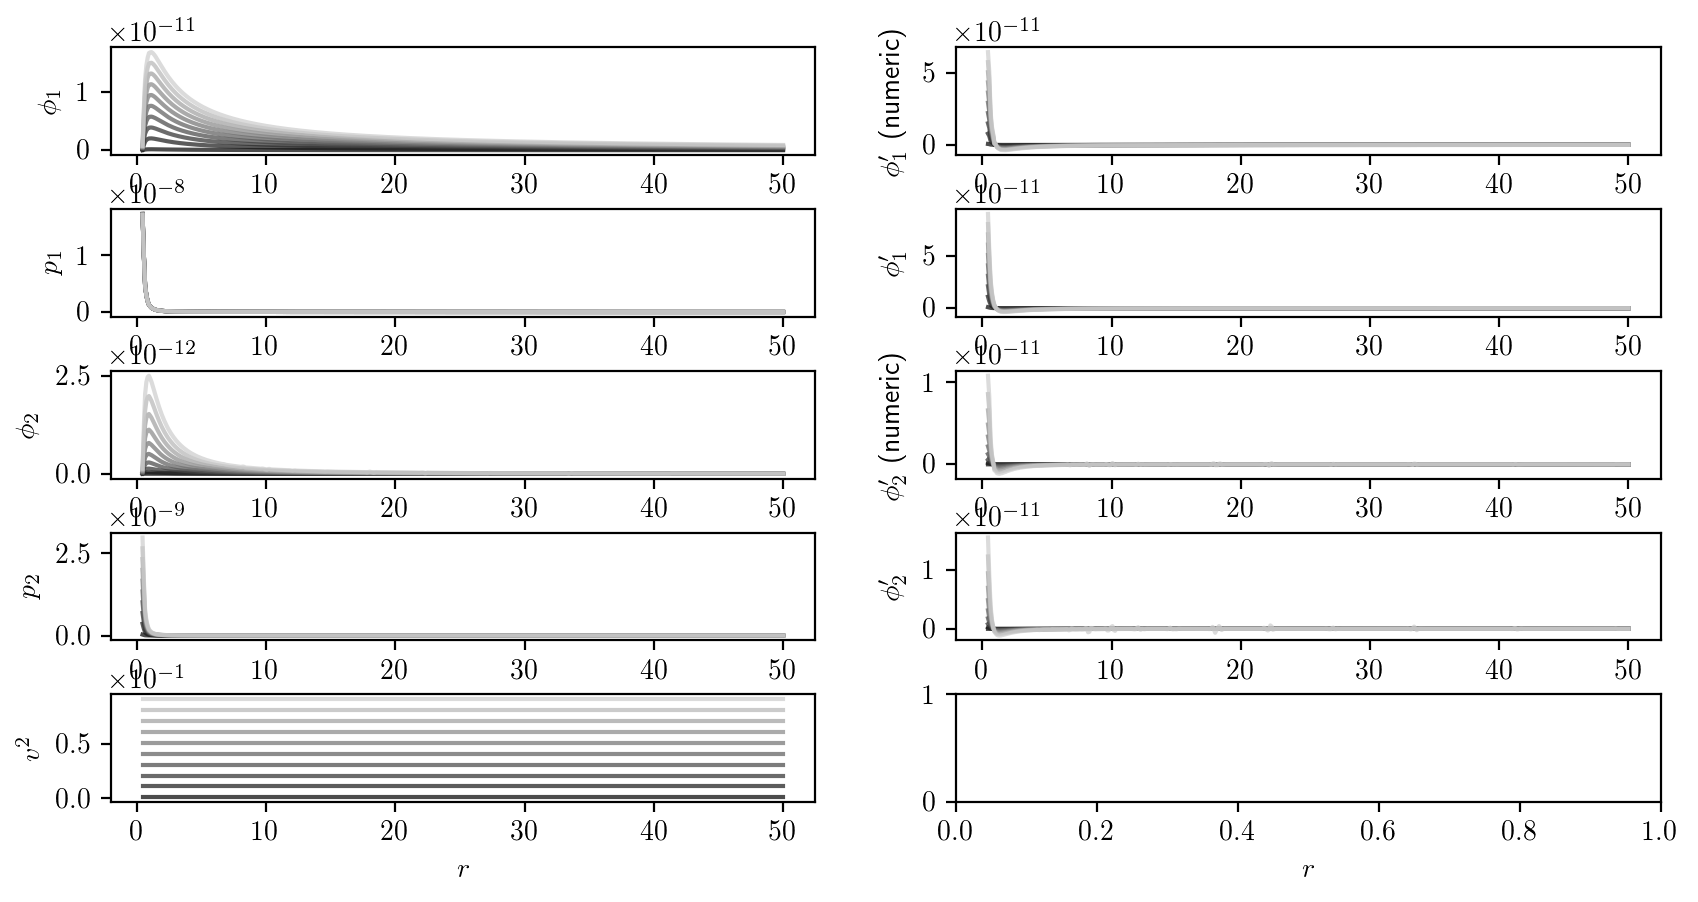

Metric contents


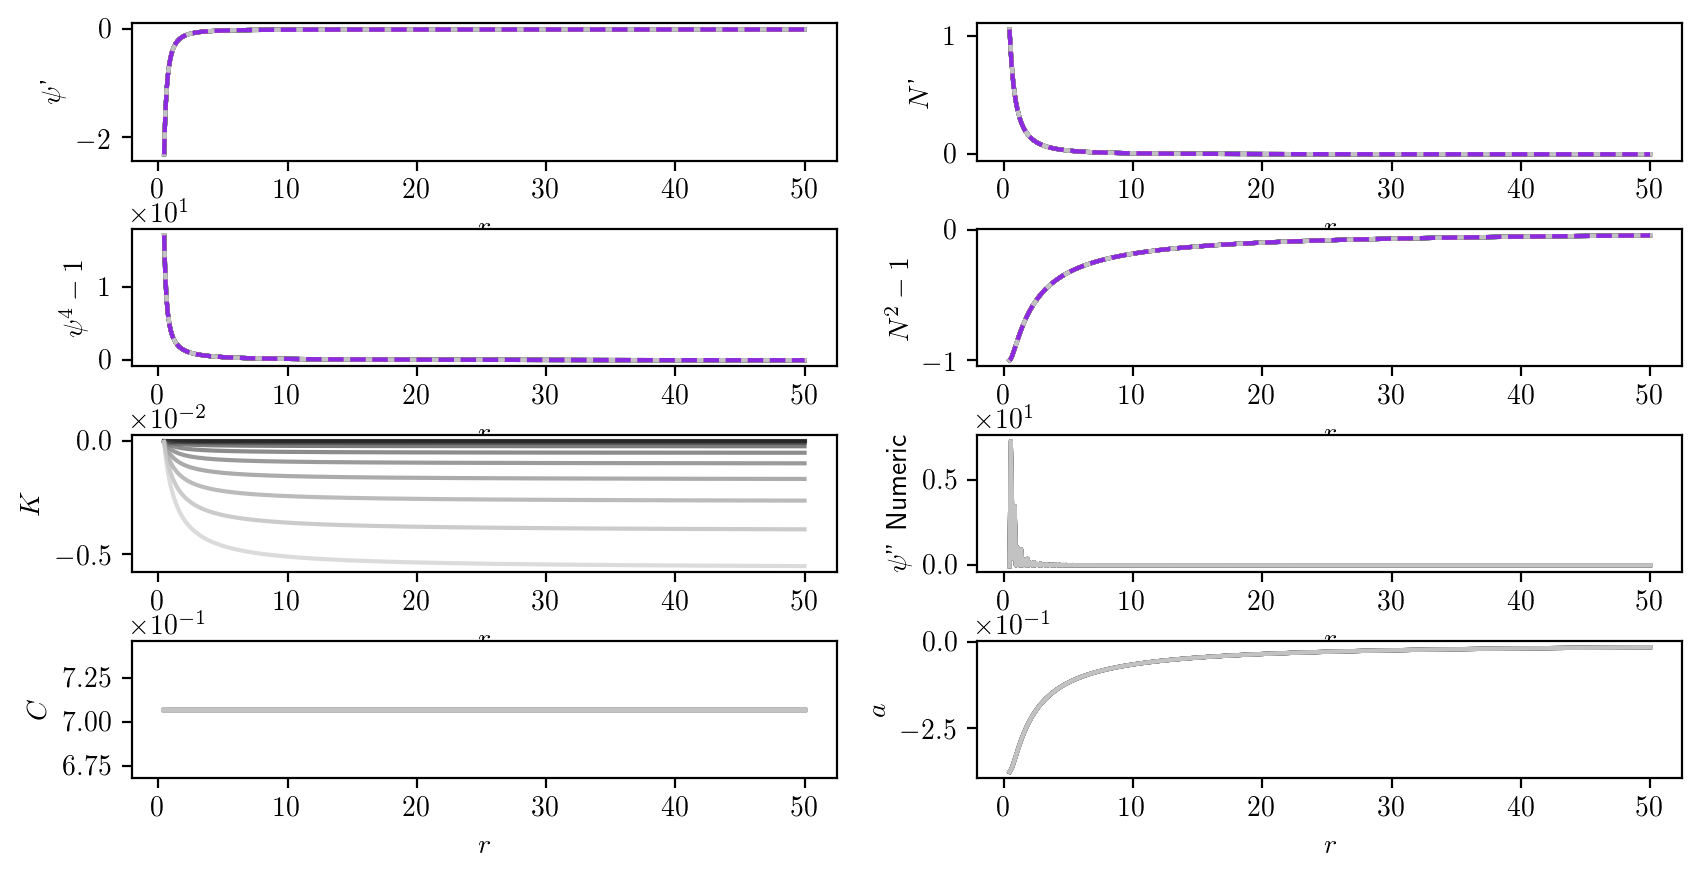

In [372]:
print("file name: " + read_file)
print("length of time steps: ", len(t_all))
plot_t_slice_fields(\
                    np.transpose([A_file_result, B_file_result, C_file_result, psi_file_result, N_file_result, a_file_result,\
                    vev_file_result, phi_1_file_result, phi_2_file_result, p_1_file_result, p_2_file_result,\
                    phi_1_dr_file_result, phi_2_dr_file_result, K_file_result ]),\
                    time_range, rr_plot, log=False)
plot_t_slice_metric(\
                    np.transpose([A_file_result, B_file_result, C_file_result, psi_file_result, N_file_result, a_file_result,\
                    vev_file_result, phi_1_file_result, phi_2_file_result, p_1_file_result, p_2_file_result,\
                    phi_1_dr_file_result, phi_2_dr_file_result, K_file_result ]),\
                    time_range, rr_plot, log=False)
#plot_t_slice([1,1000],rr_plot)